Setting up training generator...
Found 5216 images belonging to 2 classes.
Setting up test generator...
Found 624 images belonging to 2 classes.
Computed class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8252 - loss: 0.3863 - val_accuracy: 0.8670 - val_loss: 0.3249
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.8944 - loss: 0.2432 - val_accuracy: 0.8718 - val_loss: 0.2983
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9103 - loss: 0.2101 - val_accuracy: 0.8734 - val_loss: 0.2675
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9174 - loss: 0.1930 - val_accuracy: 0.8830 - val_loss: 0.2624
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9229 - loss: 0.1761 - val_accuracy: 0.8782 - val_loss: 0.2697
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.9270 - loss: 0.1657 - val_accuracy: 0.8798 - val_loss: 0.2848
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9250 - loss: 0.1696 - val_accuracy: 0.8798 - val_loss: 0.2566
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9287 - loss: 0.1645 - val_accu

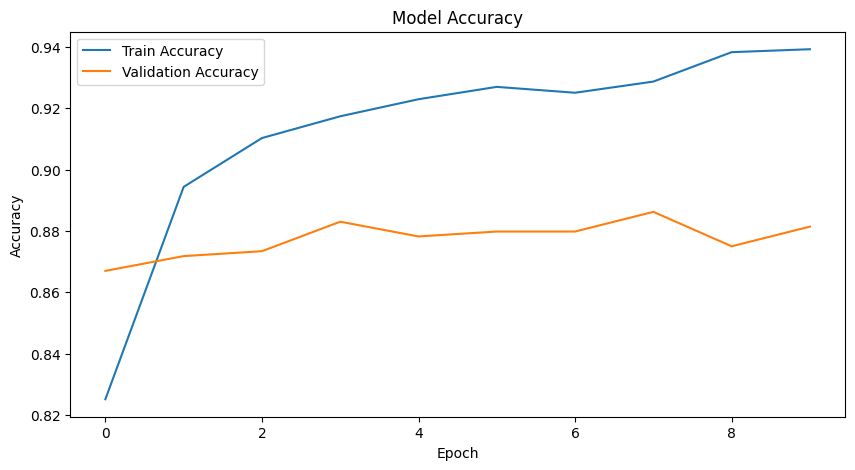

Evaluating on test data...
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 579ms/step - accuracy: 0.8814 - loss: 0.2592
✅ Test Accuracy: 88.14%
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 654ms/step


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# --- Directories ---
train_dir = r"C:\Users\HP\Downloads\Xray\train"
test_dir  = r"C:\Users\HP\Downloads\Xray\test"

# --- Data Preprocessing ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# --- Check class distribution ---
unique, counts = np.unique(train_gen.classes, return_counts=True)
print(dict(zip(train_gen.class_indices.keys(), counts)))

# --- Class weights ---
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# --- Base Model ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True  # Fine-tune

# Unfreeze last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# --- Model Architecture ---
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- Training ---
steps_per_epoch = math.ceil(train_gen.samples / BATCH_SIZE)
validation_steps = math.ceil(test_gen.samples / BATCH_SIZE)

history = model.fit(
    train_gen,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_gen,
    validation_steps=validation_steps,
    class_weight=class_weights
)

# --- Evaluate ---
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

# --- Predictions ---
pred_probs = model.predict(test_gen)
y_pred = (pred_probs > 0.4).astype(int).flatten()  # Lower threshold for better balance
y_true = test_gen.classes

# --- Confusion Matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

print(classification_report(y_true, y_pred, target_names=['Normal','Pneumonia']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(pd.DataFrame(cm, index=['Normal','Pneumonia'], columns=['Pred_Normal','Pred_Pneumonia']),
            annot=True, fmt='d', cmap='Blues')
plt.show()

# --- Display Mixed Predictions ---
def display_10_sample_predictions(model, test_generator, class_names):
    test_generator.reset()
    x_test, y_true = next(test_generator)
    y_pred = model.predict(x_test[:10])
    y_pred_labels = (y_pred > 0.4).astype(int).reshape(-1)
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[i])
        true_label = class_names[int(y_true[i])]
        pred_label = class_names[y_pred_labels[i]]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


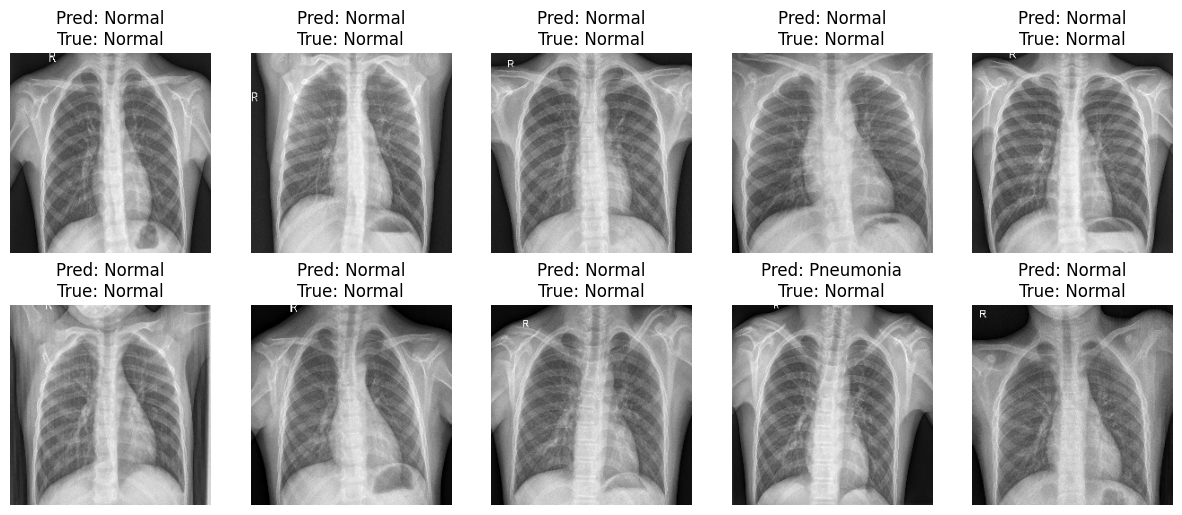

In [ ]:
class_names = ['Normal', 'Pneumonia']
display_10_sample_predictions(model, test_gen, class_names)